In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import operator
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

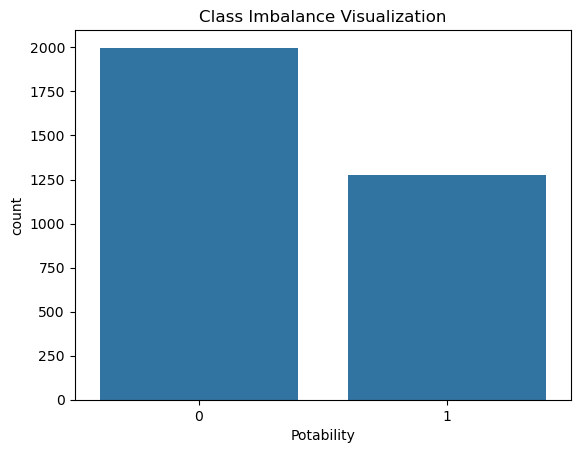

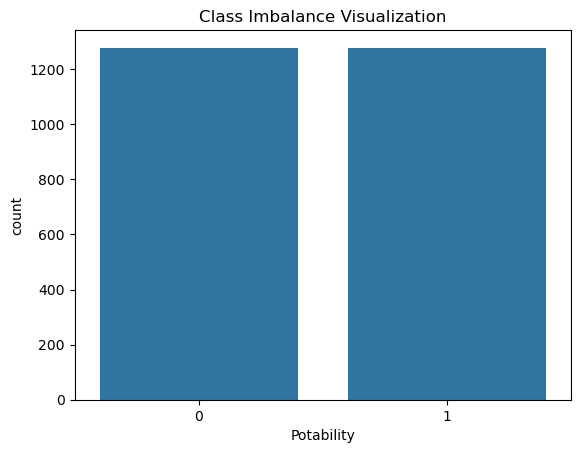

In [19]:

df = pd.read_csv('water_potability.csv')
X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 

sns.countplot(x=y)
plt.title("Class Imbalance Visualization")
plt.show()

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
df = pd.concat([X_resampled, y_resampled], axis=1)  # This creates a balanced df

X = df.iloc[:, :-1]  
y = df.iloc[:, -1] 
# Split the dataset into training and testing sets

sns.countplot(x=y)
plt.title("Class Imbalance Visualization")
plt.show()






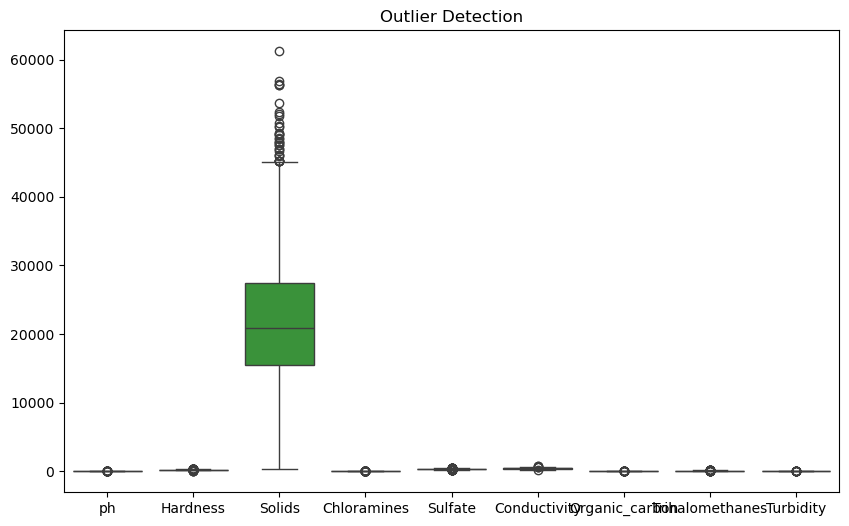

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.title("Outlier Detection")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 2556 entries, 416 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2184 non-null   float64
 1   Hardness         2556 non-null   float64
 2   Solids           2556 non-null   float64
 3   Chloramines      2556 non-null   float64
 4   Sulfate          1947 non-null   float64
 5   Conductivity     2556 non-null   float64
 6   Organic_carbon   2556 non-null   float64
 7   Trihalomethanes  2427 non-null   float64
 8   Turbidity        2556 non-null   float64
 9   Potability       2556 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 219.7 KB
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2184.000000  2556.000000   2556.000000  2556.000000  1947.000000   
mean      7.085754   196.227080  22028.619440     7.121046   333.323422   
std       1.559554    33.289700   8886.357029     1.624426    42.57

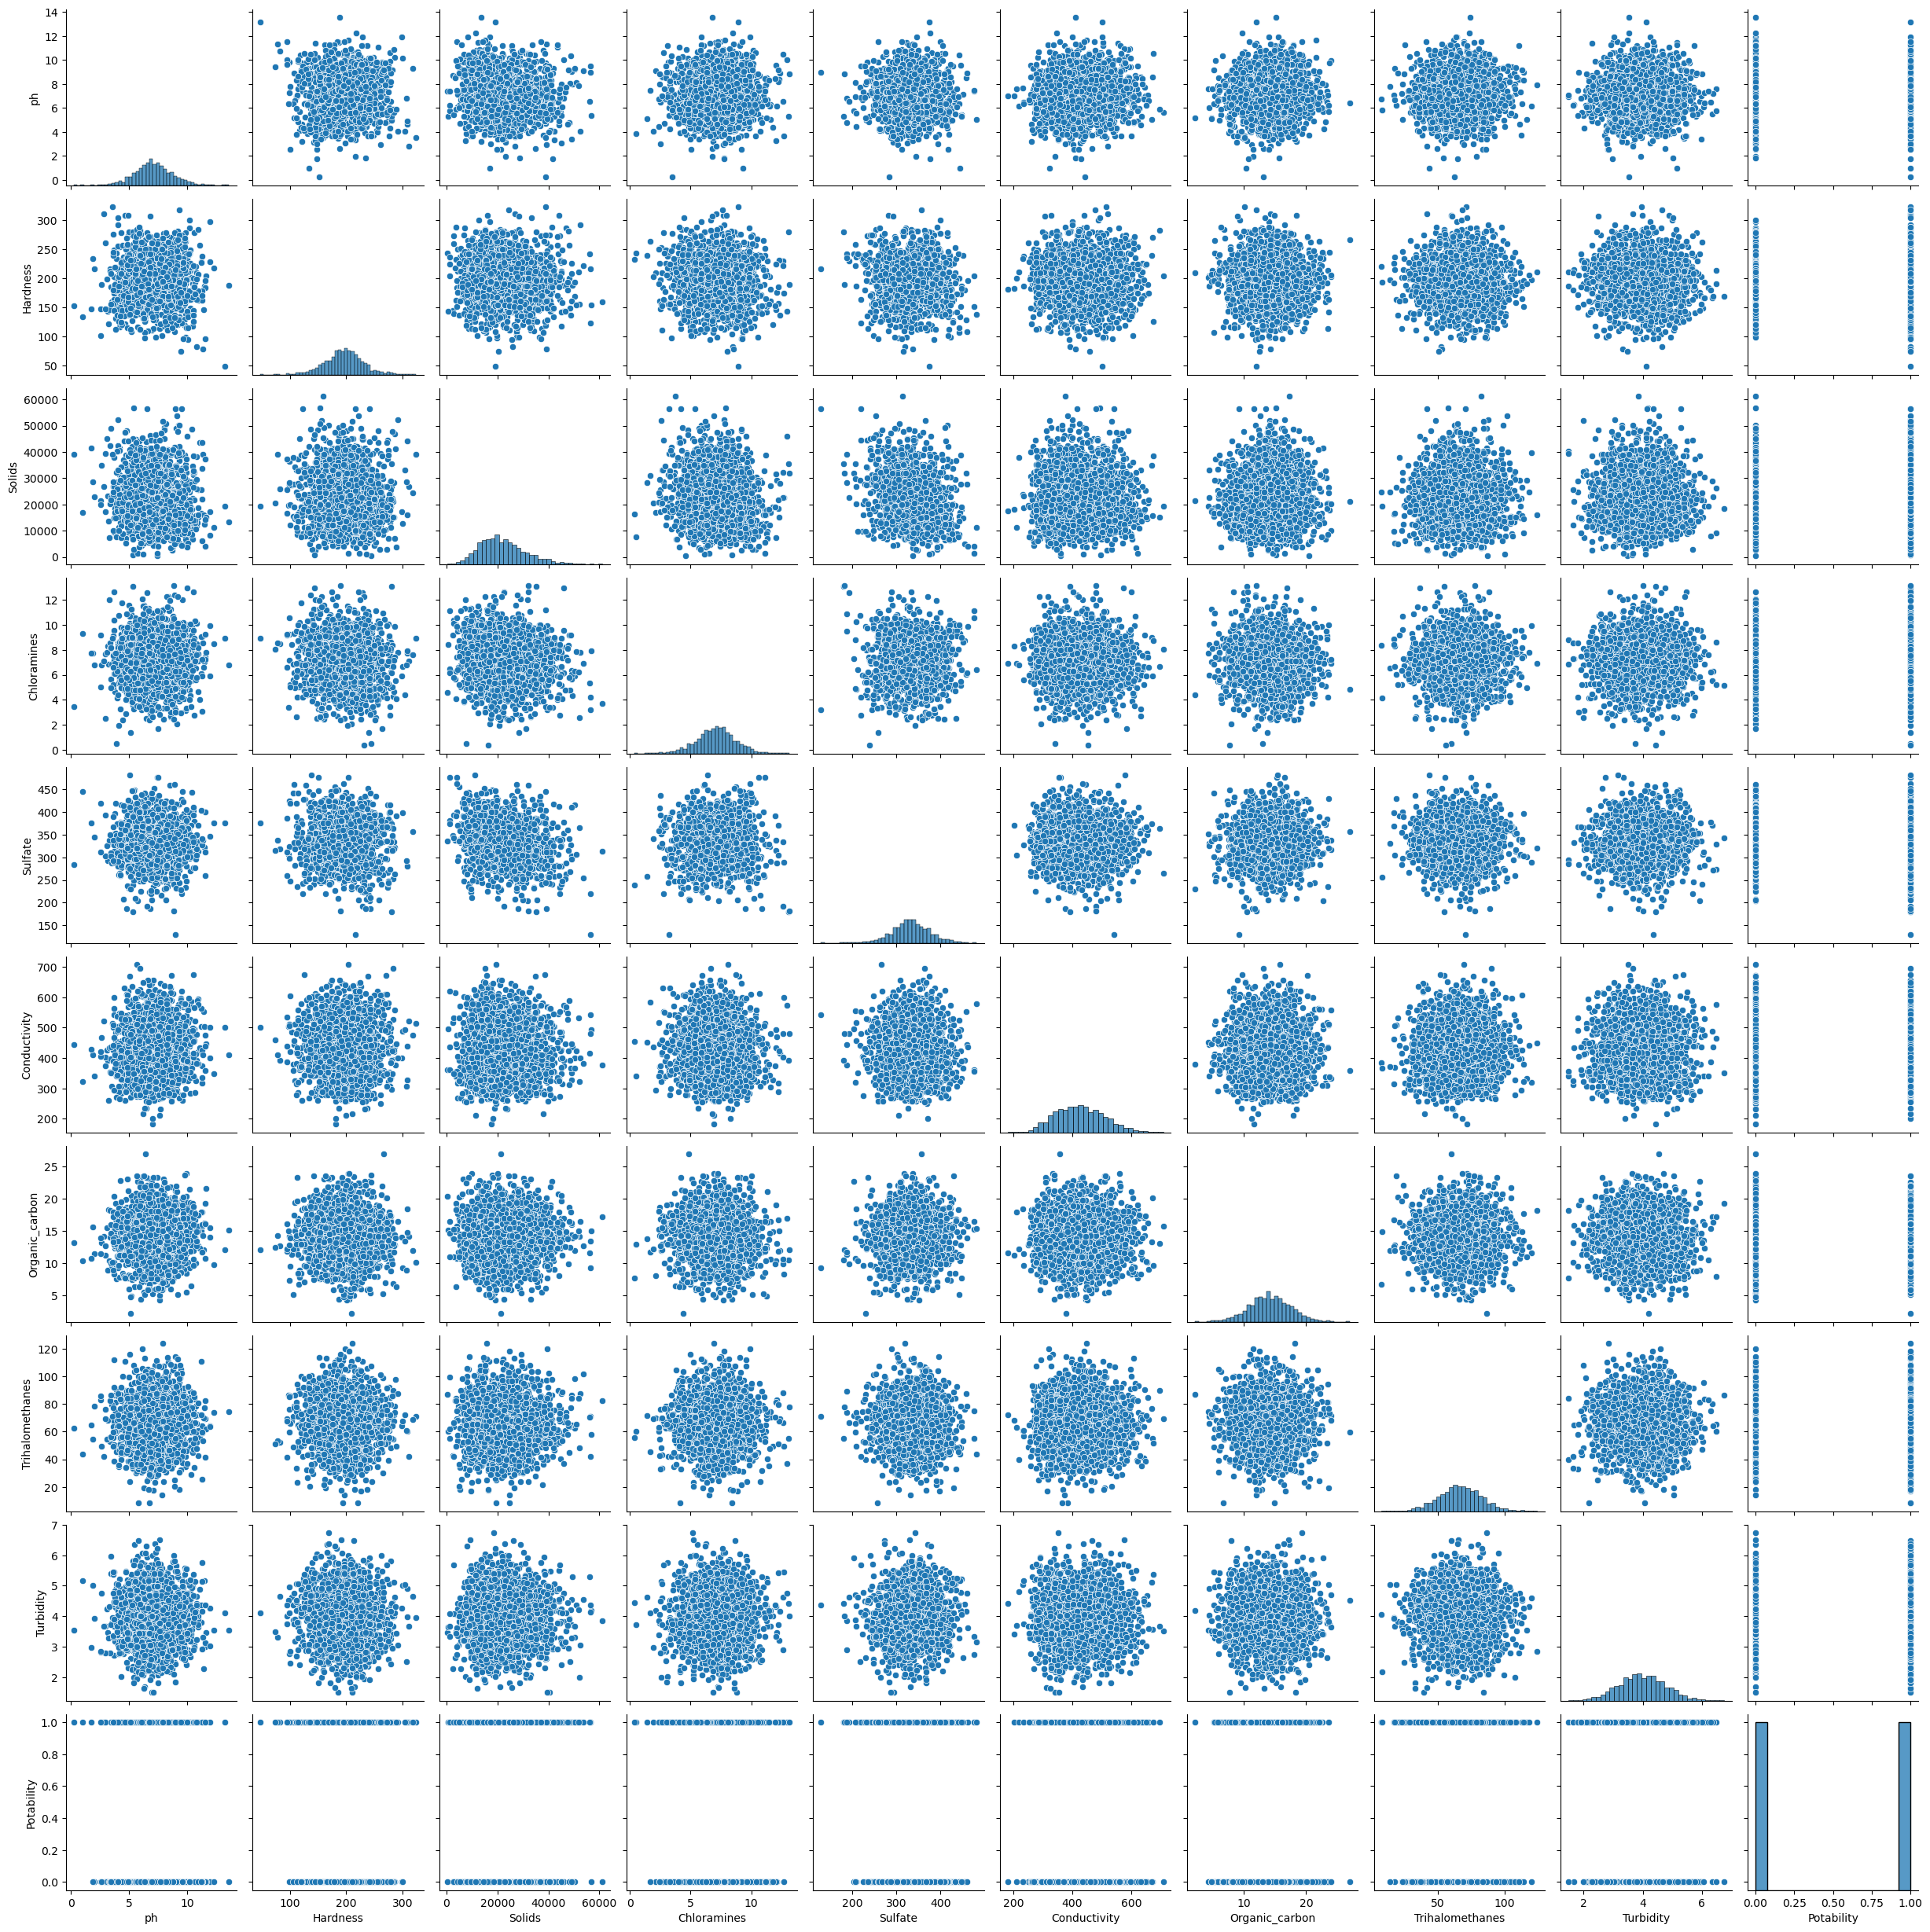

0


ph                 372
Hardness             0
Solids               0
Chloramines          0
Sulfate            609
Conductivity         0
Organic_carbon       0
Trihalomethanes    129
Turbidity            0
Potability           0
dtype: int64

In [21]:
df.info() 
print(df.describe() )
sns.pairplot(df) 
plt.show()

print(df.duplicated().sum())
# df = df.drop_duplicates()

df.isnull().sum()

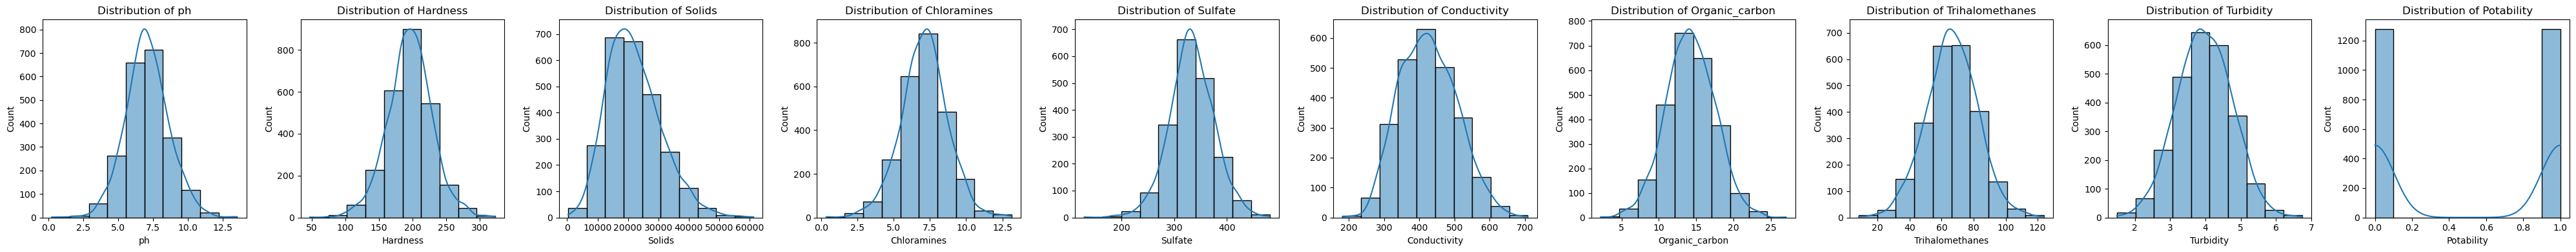

In [22]:
fig, axes = plt.subplots(1, len(df.columns), figsize=(4 * len(df.columns), 4))  # Adjusting size 

# Loop through numeric columns and create distribution plots
for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], bins=10)  # Adjust bins for smaller size
    axes[i].set_title(f'Distribution of {column}')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


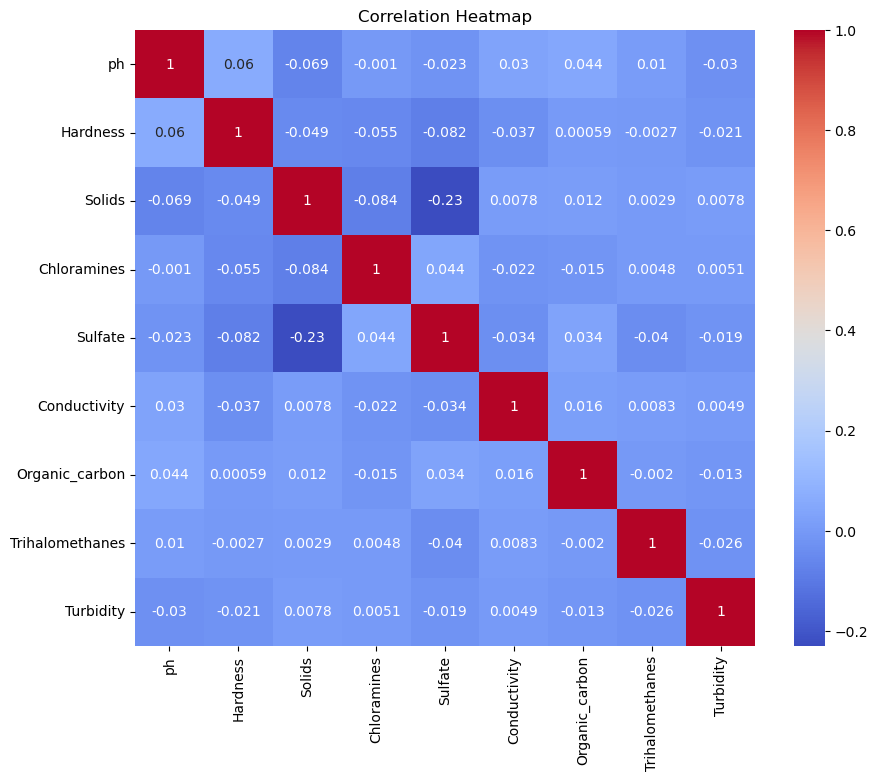

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## MANUAL PREPROCESSING ENDED 

In [24]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='zscore', threshold=3):
        self.method = method
        self.threshold = threshold
    
    def fit(self, X, y=None):
        if self.method == 'zscore':
            self.mean_ = X.mean()
            self.std_ = X.std()
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.method == 'zscore':
            z_scores = (X - self.mean_) / self.std_
            X[(z_scores > self.threshold) | (z_scores < -self.threshold)] = np.nan
        elif self.method == 'iqr':
            Q1 = X.quantile(0.25)
            Q3 = X.quantile(0.75)
            IQR = Q3 - Q1
            X[(X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))] = np.nan
        return X


In [25]:

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        # Feature engineering logic here (add if needed)
        return X_transformed

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X_train.columns  # Assuming first 10 columns are numeric
numeric_transformer = Pipeline(steps=[
    ('outlier', OutlierTransformer(method='zscore', threshold=3)),
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson'))
])


In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

In [28]:
#Applying Multiple Models
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
logistic = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(probability=True, random_state=42)  # probability=True for ROC/AUC
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

models = {
    'Random Forest': rf,
    'KNN': knn,
    'Decision Tree': dt,
    'Bagging': bagging,
    'Boosting': boosting,
    'Logistic Regression': logistic,
    'SVM': svm,
    'XGBoost': xgb,
}


In [29]:
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {model_name} ---")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend()
        plt.show()

In [30]:
for model_name, model in models.items():
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Defining the hyperparameter grid based on different Models 
    if isinstance(model, RandomForestClassifier):
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'preprocessor__num__scaler': [StandardScaler(), None],
        }
    elif isinstance(model, KNeighborsClassifier):
        param_grid = {
            'classifier__n_neighbors': [3, 5, 7, 9],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'preprocessor__num__scaler': [StandardScaler(), None],
        }
    elif isinstance(model, DecisionTreeClassifier):
        param_grid = {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__splitter': ['best', 'random'],
            'classifier__max_depth': [None, 5, 10, 15],
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'preprocessor__num__scaler': [StandardScaler(), None],
        }
    elif isinstance(model, SVC):
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'preprocessor__num__scaler': [StandardScaler(), None],
        }
    elif isinstance(model, XGBClassifier):
        param_grid = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
        }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)

    print(f"\n--- {model_name} ---")
    print("Best parameters found: ", grid_search.best_params_)


--- Random Forest ---
Best parameters found:  {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}

--- KNN ---
Best parameters found:  {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': None}

--- Decision Tree ---
Best parameters found:  {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__splitter': 'best', 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}


ValueError: Invalid parameter 'criterion' for estimator BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42). Valid parameters are: ['bootstrap', 'bootstrap_features', 'estimator', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].